# 2R Robot - Group

In [27]:
import math
from typing import Any, Optional

import numpy as np
import pybullet as p

PI = math.pi
BOUNDS = tuple[float, float]
XY = tuple[float, float]


class Robot2R:
    """Implements Forward and Inverse Kinematics of 2R Robot"""

    CONFIG = tuple[float, float]

    def __init__(
        self,
        link_lengths: tuple[float, float],
        bounds: Optional[tuple[BOUNDS, BOUNDS]] = None,
    ) -> None:
        if link_lengths[0] > link_lengths[1] and link_lengths[1] > 0:
            self.l1 = link_lengths[0]
            self.l2 = link_lengths[1]
        else:
            print("Error: Invalid link_lengths")
            self.l1, self.l2 = None, None

        if bounds != None:
            (self.lb1, self.ub1) = bounds[0][0], bounds[0][1]
            (self.lb2, self.ub2) = bounds[1][0], bounds[1][1]
        else:
            self.lb1, self.ub1, self.lb2, self.ub2 = None, None, None, None

    def forward_kinematics(self, configuration: CONFIG) -> XY:
        l1, l2 = self.l1, self.l2
        a1, a2 = configuration[0], configuration[1]
        
        if not self.__within_bounds(a1, a2):
            print("Error: Impossible configuration.")
            return

        l1 = self.l1
        l2 = self.l2

        x = l1 * math.cos(a1) + l2 * math.cos(a1 + a2)
        y = l1 * math.sin(a1) + l2 * math.sin(a1 + a2)

        return (x, y)

    def inverse_kinematics(self, end_effector_position: XY) -> CONFIG:
        x, y = end_effector_position[0], end_effector_position[1]
        l1, l2 = self.l1, self.l2
        
        cos_a2 = (x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2)

        if math.fabs(cos_a2) > 1:
            print(f"Error: Position {XY} is not within workspace")
            return 

        elif math.fabs(cos_a2) == 1:
            a1 = math.atan2(y, x)
            a2 = math.acos(cos_a2)
            
            if self.__within_bounds(a1, a2):
                return (a1, a2)
            else:
                print(f"Error: Position {XY} is not within bounds")
                return 
        
        else:
            aXY = [math.atan2(y,x)]*2  # angles towards reference
            a2 = [math.acos(cos_a2), -math.acos(cos_a2)] # elbow up or down
            a1 = aXY - np.arctan2(l2*np.sin(a2), l1 + l2*np.cos(a2))

            config = [] 

            for i in range(2):
                if self.__within_bounds(a1[i], a2[i]):
                    config.append((a1[i], a2[i]))

            if config:
                return config[0] # Returns elbow-up solution first if valid
            else:
                print(f"Error: Position {XY} is not within bounds")
                return 

    def __within_bounds(self, a1, a2):
        """Return whether congfiguration is within bounds"""
        within_bounds = True

        if self.lb1 and self.lb2 and self.ub1 and self.ub2:
            lb1, lb2, ub1, ub2 = self.lb1, self.lb2, self.ub1, self.ub2
            if not (lb1 <= a1 <= ub1 and lb2 <= a2 <= ub2):
                within_bounds = False

        return within_bounds
                


class Robot3R:
    CONFIG = tuple[float, float, float]

    def __init__(
        self,
        link_lengths: tuple[float, float, float],
        bounds: Optional[tuple[BOUNDS, BOUNDS, BOUNDS]] = None,
    ) -> None:
        raise NotImplementedError("3R Robot not implemented")
        ...

    def forward_kinematics(self, configuration: CONFIG) -> XY:
        ...

    def inverse_kinematics(self, end_effector_position: XY) -> CONFIG:
        ...


class RobotIiwa:
    def __init__(
        self,
        robot_urdf: str,
        initial_pos: list[float],
        initial_orientation: list[float],
    ) -> None:
        self.id = p.loadURDF(robot_urdf, initial_pos, initial_orientation)

        self.__control_mode = p.POSITION_CONTROL
        self.__joint_ids = list(range(p.getNumJoints(self.id)))

    def send_command(self, command: list[float]) -> None:
        assert len(command) == len(self.__joint_ids)
        p.setJointMotorControlArray(
            self.id, self.__joint_ids, self.__control_mode, targetPositions=command
        )

    def get_states(self) -> Any:
        return p.getJointStates(self.id, self.__joint_ids)

    def get_positions(self) -> list[float]:
        return [state[0] for state in self.get_states()]

    def get_velocities(self) -> list[float]:
        return [state[1] for state in self.get_states()]


## Testing - Group

In [69]:
import math
import numpy as np
from numpy import random
from pytest import approx

pi = math.pi


def create_robot():
    link_lengths = (50, 40)
    test_robot = Robot2R(link_lengths)
    return test_robot

def create_robot_wbounds():
    link_lengths = (60.0, 40.0)
    bounds = ((-2*pi, 2*pi),(-3/4*pi, 3/4*pi))
    test_robot = Robot2R(link_lengths, bounds)
    return test_robot

def test_forward_kinematics():
    robot = create_robot()

    # Edge cases
    assert approx(robot.forward_kinematics((0, 0))) == (90, 0)
    assert approx(robot.forward_kinematics((pi / 2, 0))) == (0, 90)
    assert approx(robot.forward_kinematics((-pi / 2, 0))) == (0, -90)
    assert approx(robot.forward_kinematics((pi / 6, 0))) == (math.sqrt(3) * 45, 45)

    r = np.linspace(10, 87, num=100)
    t = np.linspace(-pi, pi, 100)
    for theta in t:
        for radius in r:
            (x, y) = (radius*math.cos(theta), radius*math.sin(theta))
            assert approx(robot.forward_kinematics(robot.inverse_kinematics((x,y)))) == (x,y)


def test_inverse_kinematics():
    robot = create_robot()

    # Edge cases
    assert approx(robot.inverse_kinematics((90, 0))) == (0, 0)
    assert approx(robot.inverse_kinematics((0, 90))) == (pi / 2, 0)
    assert approx(robot.inverse_kinematics((0, -90))) == (-pi / 2, 0)
    assert approx(robot.inverse_kinematics((math.sqrt(3) * 45, 45))) == (pi / 6, 0)

    # Testing configuration space
    a1_ub = pi - math.tan(4/3) # Restriction added to prevent: (x,y) in Q3 while a2 > 0
    a1 = random.uniform(low=-pi, high=a1_ub, size=(100,))
    a2 = random.uniform(low=0.0, high=pi, size=(100,))

    configurations = []
    for x in a1:
        for y in a2:
            configurations.append((x,y))
    configs = np.array(configurations)

    for i in range(configs.shape[0]):
        assert (
            approx(
                robot.inverse_kinematics(
                    robot.forward_kinematics(configs[i])
                )
            )
            == configs[i]
        )

def test_daniel():
    ## Testing ##
    link_lengths = (30, 20)
    bounds = (-2 * math.pi, 2 * math.pi)

    testclass = Robot2R(link_lengths)

    configuration_1 = (math.pi, math.pi / 2)
    test_1 = testclass.forward_kinematics(configuration_1)
    assert approx(test_1) == (-30, -20)

    test_2 = testclass.inverse_kinematics(testclass.forward_kinematics(configuration_1))
    test_2 = np.abs(test_2)
    assert approx(test_2) == configuration_1

    configuration_3 = (-math.pi / 2, 0)
    test_3 = testclass.forward_kinematics(configuration_3)
    assert approx(test_3) == (0, -50)

def test_bounds():
    test_robot = create_robot_wbounds()

    # Forward Kinematics 
    configuration1 = (pi/3, pi)
    test1 = test_robot.forward_kinematics(configuration1)
    assert test1 == None

    configuration2 = (3*pi, 0)
    assert test_robot.forward_kinematics(configuration2) == None

    # Inverse Kinematics
    xRef_OutsidePositionalSpace = (110, 0)
    assert test_robot.inverse_kinematics(xRef_OutsidePositionalSpace) == None

    xRef_InsidePositionalSpace = (19, 0)
    assert test_robot.inverse_kinematics(xRef_InsidePositionalSpace) == None

In [70]:
test_forward_kinematics()
test_inverse_kinematics()
test_daniel()
test_bounds()

Error: Impossible configuration.
Error: Impossible configuration.
Error: Position tuple[float, float] is not within workspace
Error: Position tuple[float, float] is not within workspace


# 2R Robot - Elijah

In [1]:
# Importing dependencies
from typing import Any, Optional
import pybullet as p

# Defning data types
BOUNDS = tuple[float, float]
XY = tuple[float, float]
CONFIG = tuple[float, float]

## Forward Kinematics

*Given a valid configuration $\theta_1, \theta_2$, find the position of the end effector*


Here, we can use a homogeneous transformation to represent the pose of the second link relative to the pose of the first.

$
T_{12} = 
\begin{bmatrix} 
	\cos{\theta_1} & -\sin{\theta_1} & l1 \times \cos{\theta_1} \\
	\sin{\theta_1} & \cos{\theta_1} & l1 \times \sin{\theta_1} \\
	0 & 0 & 1 \\
	\end{bmatrix}
$

Then, $ {P}_1 = T_{12} * {P}_2 $

Where $P's$ are position of end effector relative to pose of first and second link.

In [30]:
class Robot2R:
    """Implements Forward and Inverse Kinematics of 2R Robot"""

    CONFIG = tuple[float, float]

    def __init__(
        self,
        link_lengths: tuple[float, float],
        bounds: Optional[tuple[BOUNDS, BOUNDS]] = None,
    ) -> None:
        self.l1 = link_lengths[0]
        self.l2 = link_lengths[1]

        if bounds:
            (self.lb1, self.ub1) = bounds[0][0], bounds[0][1]
            (self.lb2, self.ub2) = bounds[1][0], bounds[1][1]
        else:
            self.lb1, self.ub1, self.lb2, self.ub2 = None, None, None, None

    def forward_kinematics(self, configuration: CONFIG) -> XY:
        l1, l2 = self.l1, self.l2
        a1, a2 = configuration[0], configuration[1]
        if self.lb1:
            lb1, lb2, ub1, ub2 = self.lb1, self.lb2, self.ub1, self.ub2
            if not (
                lb1 <= a1 <= ub1 and lb2 <= a2 <= ub2
            ):  # configuration not within bounds
                print("Error: Impossible configuration.")
                return

        cos = math.cos
        sin = math.sin

        T_12 = np.array(
            [  # Creating Transformation matrix from R1->R2
                [cos(a1), -sin(a1), l1 * cos(a1)],
                [sin(a1), cos(a1), l1 * sin(a1)],
                [0, 0, 1],
            ]
        )

        xy_2 = np.array([l2 * cos(a2), l2 * sin(a2), 1])
        XY_1 = np.dot(T_12, xy_2)

        (x, y) = XY_1[0], XY_1[1]

        return (x, y)

    def inverse_kinematics(self, end_effector_position: XY) -> CONFIG:
        x, y = end_effector_position[0], end_effector_position[1]
        l1, l2 = self.l1, self.l2

        fraction = (x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2)

        if -1 < fraction > 1:  # Out of working space
            print("No IK solution found")
            return

        elif fraction == 1:  # Both joints aligned
            return (math.atan2(y, x), 0)

        ### First solution
        a2 = math.acos(fraction)
        if x != 0:
            a1 = math.atan2(y, x) - math.atan2(
                l2 * math.sin(a2), l1 + l2 * math.cos(a2)
            )
        solution1 = (a1, a2)

        ### Second solution
        second_a2 = -a2
        if x != 0:
            second_a1 = math.atan(y / x) - math.atan(
                (l2 * math.sin(second_a2)) / (l1 + l2 * math.cos(second_a2))
            )
        solution2 = (second_a1, second_a2)

        if self.lb1:
            lb1, lb2, ub1, ub2 = self.lb1, self.lb2, self.ub1, self.ub2
            ### Checking for solutions
            if lb1 <= a1 <= ub1 and lb2 <= a2 <= ub2:
                if lb1 <= second_a1 <= ub1 and lb2 <= second_a2 <= ub2:
                    print("Two solutions found:", solution1, solution2)
                return solution1

            elif lb1 <= second_a1 <= ub1 and lb2 <= second_a2 <= ub2:
                return solution2

            else:
                print("No IK solution found")
                return
        else:
            return solution1

For testing we will use `pytest` and `doctest` for unit testing

In [26]:
import math
from numpy import random
import numpy as np
pi = math.pi
def create_robot():
    link_lengths = (50, 40)
    test_robot = Robot2R(link_lengths)
    return test_robot

robot = create_robot()

In [5]:
############ Forward Kinematics Tests #############
pi = math.pi

link_lengths = (60.0, 40.0)
bounds = ((-2*pi, 2*pi),(-3/4*pi, 3/4*pi))

# Creating 2R robot
testRobot = Robot2R(link_lengths, bounds)

configuration1 = (pi/2,-pi/2)
test1 = testRobot.forward_kinematics(configuration1)
print(test1, "should be 40, 60")

configuration2 = (0, pi/4)
test2 = testRobot.forward_kinematics(configuration2)
print(test2, "should be", 60 + 40*math.cos(pi/4), 40*math.sin(pi/4))

configuration3 = (pi/3, pi)
test2 = testRobot.forward_kinematics(configuration3)
print("Should show an error")

(40.00000000000001, 60.0) should be 40, 60
(88.2842712474619, 28.284271247461902) should be 88.2842712474619 28.284271247461902
Should show an error


In [36]:
####### Testing Inverse Kinematics ########
robot.inverse_kinematics((0,90))

(1.5707963267948966, 0)

In [9]:

configurations = random.randint(5, high=80, size=(20, 2))

for config in configurations:
    magnitude = np.linalg.norm(config)
    if 100 <= magnitude**2 <= 8100:
        print(config, ":", robot.forward_kinematics(robot.inverse_kinematics(config)))


    

NameError: name 'random' is not defined

In [3]:
############ Forward Kinematics Tests #############
pi = math.pi

link_lengths = (60.0, 40.0)
bounds = ((-2*pi, 2*pi),(-3/4*pi, 3/4*pi))

# Creating 2R robot
testRobot = Robot2R(link_lengths, bounds)

configuration1 = (pi/2,-pi/2)
test1 = testRobot.forward_kinematics(configuration1)
print(test1, "should be 40, 60")

configuration2 = (0, pi/4)
test2 = testRobot.forward_kinematics(configuration2)
print(test2, "should be", 60 + 40*math.cos(pi/4), 40*math.sin(pi/4))

configuration3 = (pi/3, pi)
test2 = testRobot.forward_kinematics(configuration3)
print("Should show an error")

(40.00000000000001, 60.0) should be 40, 60
(88.2842712474619, 28.284271247461902) should be 88.2842712474619 28.284271247461902
Error: Impossible configuration.
Should show an error


In [51]:
a1 = random.uniform(low=-pi, high=pi, size=(50,))
a2 = random.uniform(low=0.0, high=3*pi/4, size=(50,))
configurations = np.zeros((50,2))
configurations[:,0] = a1
configurations[:,1] = a2
print(configurations)

[[ 0.01116177  0.79111813]
 [-1.42518295  1.14205987]
 [-0.79572017  1.45342287]
 [-0.18588388  1.17376717]
 [ 1.90682811  0.41162958]
 [-0.17325387  1.01341491]
 [-2.09435354  2.24386897]
 [-1.46894313  1.44540085]
 [ 0.58467849  1.03199789]
 [-2.03239624  1.10500878]
 [ 3.06075505  0.3493774 ]
 [ 3.05922256  0.48385708]
 [-0.8252469   0.06196672]
 [-0.10995831  1.12611976]
 [-1.73577022  0.37023043]
 [-2.10964658  0.24308971]
 [ 0.88639261  0.71082015]
 [-2.48521441  1.65092142]
 [-1.31268446  1.20357856]
 [ 0.26076486  0.57636707]
 [-1.5164176   0.22906555]
 [ 1.71591296  2.1808342 ]
 [-1.40294394  2.31827259]
 [-1.82739368  0.58768018]
 [ 2.9976077   1.08785132]
 [-2.45798489  0.93419917]
 [-1.53345621  1.60741094]
 [ 2.32808335  0.9177044 ]
 [-1.08463097  0.64197649]
 [ 2.8538918   2.12405024]
 [ 0.46232423  0.71364564]
 [ 2.94806419  0.21793816]
 [ 0.85341531  1.72664845]
 [-0.55412798  0.83153536]
 [-2.0310317   1.9614973 ]
 [-1.64024217  0.90931586]
 [-0.42438439  0.90754619]
 

In [4]:
############## Inverse Kinematics Tests #########
configuration1 = (pi/2,-pi/2)
test1 = testRobot.inverse_kinematics(testRobot.forward_kinematics(configuration1))
print(testRobot.forward_kinematics(test1))

Two solutions found: (0.39479111969976144, 1.5707963267948966) (1.5707963267948966, -1.5707963267948966)
(40.00000000000001, 60.0)


## Inverse Kinematics

*Given a valid position of end effector $(x,y)$ in  workspace calculate orientation of robot links $(\theta_1, \theta_2)$ in configuration space*


To solve this inverse kinematics equation, we can use trigonometry.

First, note $\theta_2$ deteremines the distance the end effector is from the origin. By the law of cosines, we see:

$x^2 + y^2  = l_1^2 + l_2^2 - 2(l_1)(l_2)cos(π-a_2)$      

Therefore,

$\frac{(x^2 + y^2)-(l_1^2 + l_2^2)}{- 2(l_1)(l_2)}=cos(π-a_2)$ 

Now we have,

$cos(π-a_2) = -cos(a_2) ⇒ $

$a_2 = \cos^{-1}(\frac{(x^2 + y^2)-(l_1^2 + l_2^2)}{2 l_1 l_2}) $

Two solutions exist for robot configuration (unless `l1 + l2 = x + y`), bottom arm up, bottom arm down. Therefore,

$a_2 = \pm \cos^{-1}(\frac{(x^2 + y^2)-(l_1^2 + l_2^2)}{2 l_1 l_2}) $ 

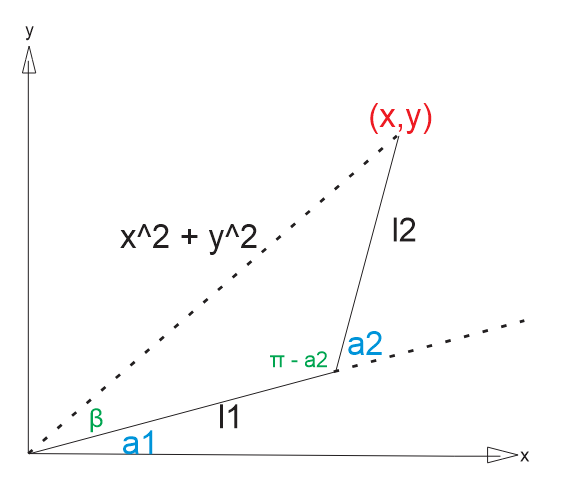

Note: as `arcos` is defined on range `[-1,1]`, we see two conditions for no solution existing:
1. $ x^2 + y^2 > (l1 + l2)^2 $       ------- (Too Far)
2. $ x^2 + y^2 < (l1 - l2)^2 $      ------(Too close)   

-------------------------
Finally, since we know `a2`, we can solve for `a1` by noting at if $a_1 = 0$, 
then end effector position is  $(l_1 + l_2cos(a2), l_2 sin(a2))$.

Therefore, if β is angle of rotation from pose 1 to pose 2

$a_1 = tan^{-1}(\frac{y}{x}) - β$, and expanded

$a_1 = tan^{-1}(\frac{y}{x}) - tan^{-1}(\frac{l_2sin(a_2)}{l_1 + l_2 \cos(a_2)})$



## Background

The `typing` module enables you to specify what *types* of inputs and outputs you expect a functions parameters and return values to be.

For example:

```python
def greeting(name: str) -> str
    return "Hello" + name
```

Also enables you to `def`ine your own types from more primitive types

```python
Vector = list[str]
```

As well as define and nest more complex data structures easily and comprehensibily

------------------------------------------

Now `pybullet` is a module used for:
* Forward kinematics
* Inverse kinamatics
* Collision detection

For more information about pybullet functions, see [documentation](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#) 

Remember the syntax for initializing an object in python (class constructor):

```python
def __init__(self, param1, param2):
    self.param1 = param1
    self.param2 = param2
```

Here we create aliases for two types of data structures. Specifically 2-tuples of floats (e.g. (5.2, 6.1))
* Bounds = Give the *interval of rotation* a given revolute can rotate [e.g. (-pi/2,pi/2)]
* XY = *(x,y)-coordinates* of the end effector
* Relative Pose of each revolute (given by an angle)


Remember the syntax for initializing an object in python (class constructor):

```python
def __init__(self, param1, param2):
    self.param1 = param1
    self.param2 = param2
```

## Robot3R

Here we implement the robot with three revolute joints.

*Specifications*

Link Lengths:  $(60 cm, 40 cm, 30 cm)$

Maximum Angles:  $([-2pi, 2pi], [-3/4pi, 3/4pi], [-3/4pi, 3/4pi])$

In [5]:
import numpy as np

class Robot3R:
    CONFIG = tuple[float, float, float]
    XYZ = tuple[float, float, float]

    def __init__(self,
                 link_lengths: tuple[float, float, float],
                 bounds: Optional[tuple[BOUNDS, BOUNDS, BOUNDS]] = None) -> None:
                 self.l1  = link_lengths[0]
                 self.l2 = link_lengths[1]
                 self.l3 = link_lengths[2]
        

    def forward_kinematics(self, configuration: CONFIG) -> XYZ:
        # Get x,y
        l1, l2,l3  = self.l1, self.l2, self.l3
        a1, a2, a3 = configuration[0], configuration[1], configuration[2]
        xyz = np.zeros(3)
        first_one = np.array([l1*math.cos(a1), l1*math.sin(a1), 0])
        xyz += first_one
        
        rotation_matrix = np.array([
            [math.cos(a1), -1*math.sin(a1), 0],
            [math.sin(a1), math.cos(a1), 0],
            [0,0,1]
        ])

        second_one = np.array([l2*math.cos(a2),0,l2*math.sin(a2)])
        second_one = rotation_matrix.dot(second_one)

        third_one = np.array([l3*math.cos(a2 + a3), 0, l3 *math.cos(a2+a3)])
        third_one = rotation_matrix.dot(third_one)

        xyz += second_one + third_one

        return (xyz[0], xyz[1], xyz[2])


    def inverse_kinematics(self, end_effector_position: XYZ) -> CONFIG:
        # (1) Unpacking parameters
        x,y,z = end_effector_position[0], end_effector_position[1], end_effector_position[2]
        l1 = self.l1

        # (2) Find angle of first robot manipulator
        a1 = math.atan(y/x)

        # (3) Rotate problem into two dimensions 
        ## Defining inverse of a1-rotation matrix - (Do not need to define inverse because)
        rotation_matrix = np.array([
            [math.cos(a1), math.sin(a1), 0],
            [-1*math.sin(a1), math.cos(a1), 0],
            [0,0,1]
        ])

        xyz =np.array([x,y,z])
        ## Getting xyz rotated into xz-plane
        new_xz = rotation_matrix.dot(xyz)
        new_xz[0] -= l1

        # (4) Now we are back to standard 2R in plane case
        # Copied code from previous problem
        x, y = new_xz[0], new_xz[1]
        l1, l2= self.l2, self.l3

        # Be careful about 0 division errors
        a3 = math.acos((x**2 + y**2 - l1**2 - l2**2) / (2*l1*l2))
        if x != 0:
            a2 = math.atan(y/x) - math.atan((l2*math.sin(a3)) / (l1 + l2 * math.cos(a3)))
        else: 
            a2 = math.pi/2 - math.atan((l2*math.sin(a3)) / (l1 + l2 * math.cos(a3)))
        
        return (a1, a2, a3)
    


In [6]:
# Creating robot
link_lengths = (10, 40, 30)
testRobot = Robot3R(link_lengths)

print(testRobot.forward_kinematics(testRobot.inverse_kinematics((10,20,20))))
print(testRobot.forward_kinematics(testRobot.inverse_kinematics((30,30,40))))

(10.00000000000001, 20.000000000000014, -42.38446452539256)
(30.000000000000007, 30.000000000000007, -24.086886158219308)


**Testing**

*Forward Kinematics*

In [7]:
test1 = testRobot.forward_kinematics((0,0,0))
print(test1, "should be:", (130, 0))

test2 = testRobot.forward_kinematics((math.pi/4, math.pi/4, math.pi/4))
print(test2, "should be", (60*math.sqrt(2)/2 - 30 * math.sqrt(2)/2, 60* math.sqrt(2)/2 + 40 + 30 * math.sqrt(2)/2))

print(testRobot.inverse_kinematics((110,0)))

(80.0, 0.0, 30.0) should be: (130, 0)
(27.07106781186548, 27.07106781186548, 28.284271247461906) should be (21.213203435596427, 103.63961030678928)


IndexError: tuple index out of range